# 데이터 소개

* 출처: https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/data 

# 신용카드 고객 이탈 예측 - EDA (Exploratory Data Analysis)

이 노트북은 신용카드 고객 이탈(Churn) 예측을 위한 기본적인 탐색적 데이터 분석을 수행합니다.

## 목차
1. 데이터 로드 및 기본 정보 확인
2. 데이터 품질 체크 (결측치, 이상치)
3. 통계적 변수 분석
4. 상관관계 분석
5. 최동 Feature Engineering 아이디어 구성


## 1. 데이터 로드 및 기본 정보 확인

In [23]:
# 필요한 라이브러리 임포트 
import pandas as pd
import numpy as np 
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# 설치된 폰트 이름으로 교체
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 사용자 
# 한글 폰트 설정 (필요시)
# plt.rcParams['font.family'] = 'DejaVu Sans' # 맥 사용자
plt.rcParams['axes.unicode_minus'] = False

In [24]:
data_path = "../../data/raw/BankChurners.csv"
df = pd.read_csv(data_path)

In [25]:
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [26]:
print(f"원본 데이터 shape: {df.shape}")
print(f"컬럼 수: {len(df.columns)}개")
print(f"이산형/문자형 컬럼 예시: {df.select_dtypes(include='object').columns[:5].tolist()}")
print(f"연속형 컬럼 수: {len(df.select_dtypes(include=np.number).columns)}개")

# 원본 프레임 미리 보기
df.head()

원본 데이터 shape: (10127, 23)
컬럼 수: 23개
이산형/문자형 컬럼 예시: ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category']
연속형 컬럼 수: 17개


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [27]:
# Attrition_Binary 생성 및 분석용 정리
if "Attrition_Flag" not in df.columns and "Attrition_Flag_Existing Customer" in df.columns:
    df["Attrition_Binary"] = df["Attrition_Flag_Existing Customer"].apply(lambda x: 0 if x else 1)
else:
    df["Attrition_Binary"] = df["Attrition_Flag"].map({
        "Existing Customer": 0,
        "Attrited Customer": 1
    })

cols_to_drop = [
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]

print("제거 대상 컬럼 및 사유: 고유 식별자 + 중복 생성된 나이브 베이즈 확률")
print(cols_to_drop)
df = df.drop(columns=cols_to_drop, errors="ignore")

print(f"정제 후 데이터 shape: {df.shape}")
print("정제 데이터 상위 5행 미리보기")
df.head()

제거 대상 컬럼 및 사유: 고유 식별자 + 중복 생성된 나이브 베이즈 확률
['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
정제 후 데이터 shape: (10127, 21)
정제 데이터 상위 5행 미리보기


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Binary
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


## 2. 데이터 품질 체크

In [28]:
# xgb_grid 프로그램 다운받기 

'xgb_grid' in globals(), 'train_test_split' in globals()  # train_test_split은 함수라 globals에서 바로 안보일 수 있음

(False, True)

In [29]:
# 'Unknown' 문자열을 결측치로 간주
unknown_values = pd.Series(dtype=int)
for col in df.select_dtypes(include='object').columns:
    unknown_count = (df[col].str.lower() == 'unknown').sum()
    if unknown_count > 0:
        unknown_values[col] = unknown_count

# 결측치 정보
missing_df = pd.DataFrame({
    'Unknown_Count': unknown_values,
    'Missing_Percent': (unknown_values / len(df)) * 100
})
missing_df = missing_df[missing_df['Unknown_Count'] > 0].sort_values('Unknown_Count', ascending=False)

if len(missing_df) > 0:
    print("결측치가 있는 컬럼 ('Unknown' 포함):")
    print(missing_df)
    print(f"\n총 결측치 비율: {(missing_df['Unknown_Count'].sum() / (len(df) * len(df.columns))) * 100:.2f}%")
else:
    print("✓ 결측치가 없습니다!")


결측치가 있는 컬럼 ('Unknown' 포함):
                 Unknown_Count  Missing_Percent
Education_Level           1519        14.999506
Income_Category           1112        10.980547
Marital_Status             749         7.396070

총 결측치 비율: 1.59%


In [30]:
# 중복 행 확인
duplicates = df.duplicated().sum()
print(f"중복 행 개수: {duplicates}")

if duplicates > 0:
    print(f"\n⚠️ 중복 행이 {duplicates}개 있습니다. 확인이 필요합니다.")
else:
    print("✓ 중복 행이 없습니다!")

중복 행 개수: 0
✓ 중복 행이 없습니다!


## 3. 통계적 변수 분석

1. 범주형 변수별 이탈률 분석

[Dependent_count]
 Dependent_count  Churn_Rate  Count
               3    0.176428   2732
               4    0.165184   1574
               2    0.157062   2655
               5    0.150943    424
               0    0.149336    904
               1    0.146355   1838

[Gender]
Gender  Churn_Rate  Count
     F    0.173572   5358
     M    0.146152   4769

[Education_Level]
Education_Level  Churn_Rate  Count
      Doctorate    0.210643    451
  Post-Graduate    0.178295    516
        Unknown    0.168532   1519
     Uneducated    0.159381   1487
       Graduate    0.155691   3128
        College    0.152024   1013
    High School    0.152012   2013

[Marital_Status]
Marital_Status  Churn_Rate  Count
       Unknown    0.172230    749
        Single    0.169414   3943
      Divorced    0.161765    748
       Married    0.151269   4687

[Income_Category]
Income_Category  Churn_Rate  Count
        $120K +    0.173315    727
 Less than $40K    0.171862   3561
        Unkn

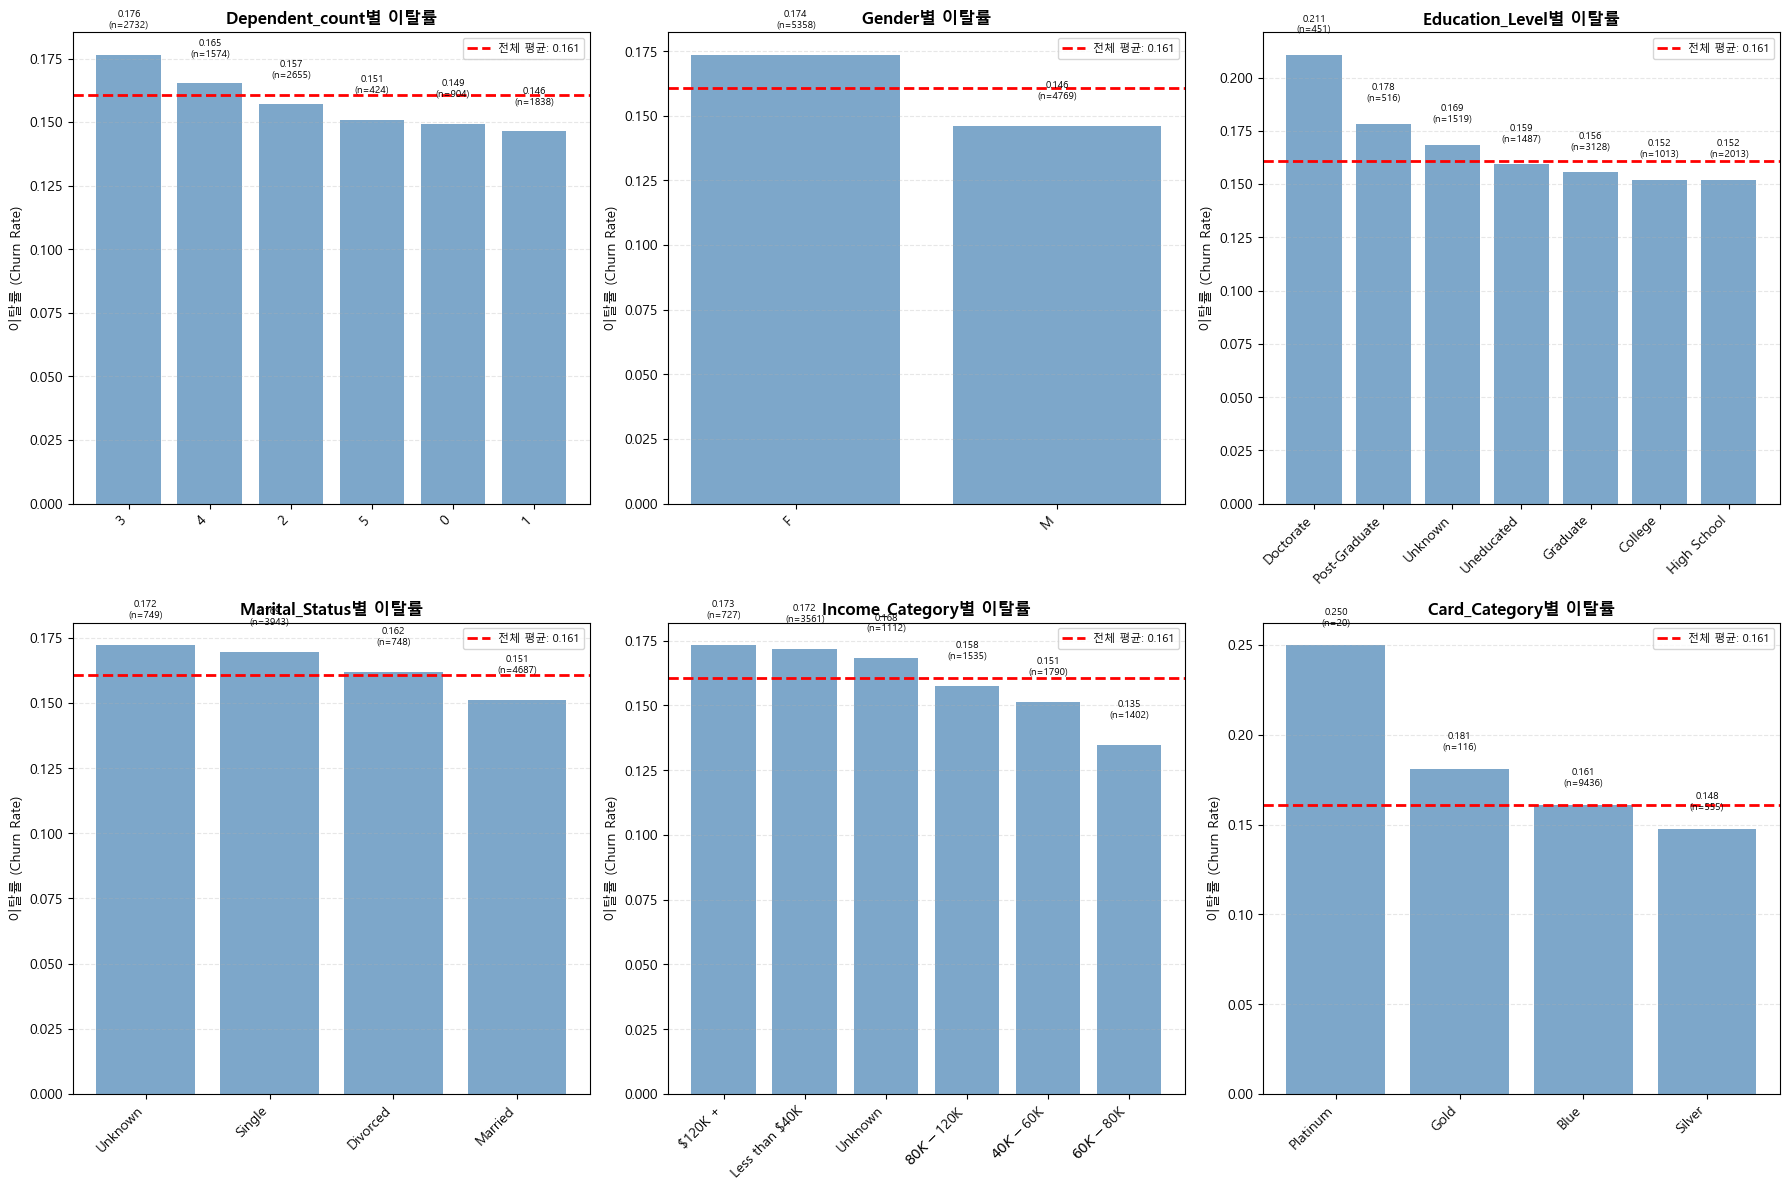


2. 연속형 변수 통계적 비교 (이탈 고객 vs 유지 고객)

통계적 검정 결과 (t-test):
                Variable  Churned_Mean  Retained_Mean   Difference  Churned_Std  Retained_Std  T_Statistic       P_Value  Cohens_D Significant
          Total_Trans_Ct     44.933620      68.672588   -23.738968    14.568429     22.919011   -40.250735  0.000000e+00 -1.089208         Yes
     Total_Revolving_Bal    672.822987    1256.604118  -583.781131   921.385582    757.745354   -27.435423 6.630148e-160 -0.742419         Yes
   Avg_Utilization_Ratio      0.162475       0.296412    -0.133937     0.264458      0.272568   -18.244911  3.357689e-73 -0.493718         Yes
         Total_Trans_Amt   3095.025814    4654.655882 -1559.630068  2308.227629   3512.772635   -17.211267  1.857439e-65 -0.465747         Yes
Total_Relationship_Count      3.279656       3.914588    -0.634932     1.577782      1.528949   -15.266725  4.829281e-52 -0.413126         Yes
            Credit_Limit   8136.039459    8726.877518  -590.838059  9095.334105   9084

C:\Users\dlaud\AppData\Local\Temp\ipykernel_28156\1028179407.py:127: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['유지 고객', '이탈 고객'],
C:\Users\dlaud\AppData\Local\Temp\ipykernel_28156\1028179407.py:127: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['유지 고객', '이탈 고객'],
C:\Users\dlaud\AppData\Local\Temp\ipykernel_28156\1028179407.py:127: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['유지 고객', '이탈 고객'],
C:\Users\dlaud\AppData\Local\Temp\ipykernel_28156\1028179407.py:127: MatplotlibDeprecationWarning: The 'label

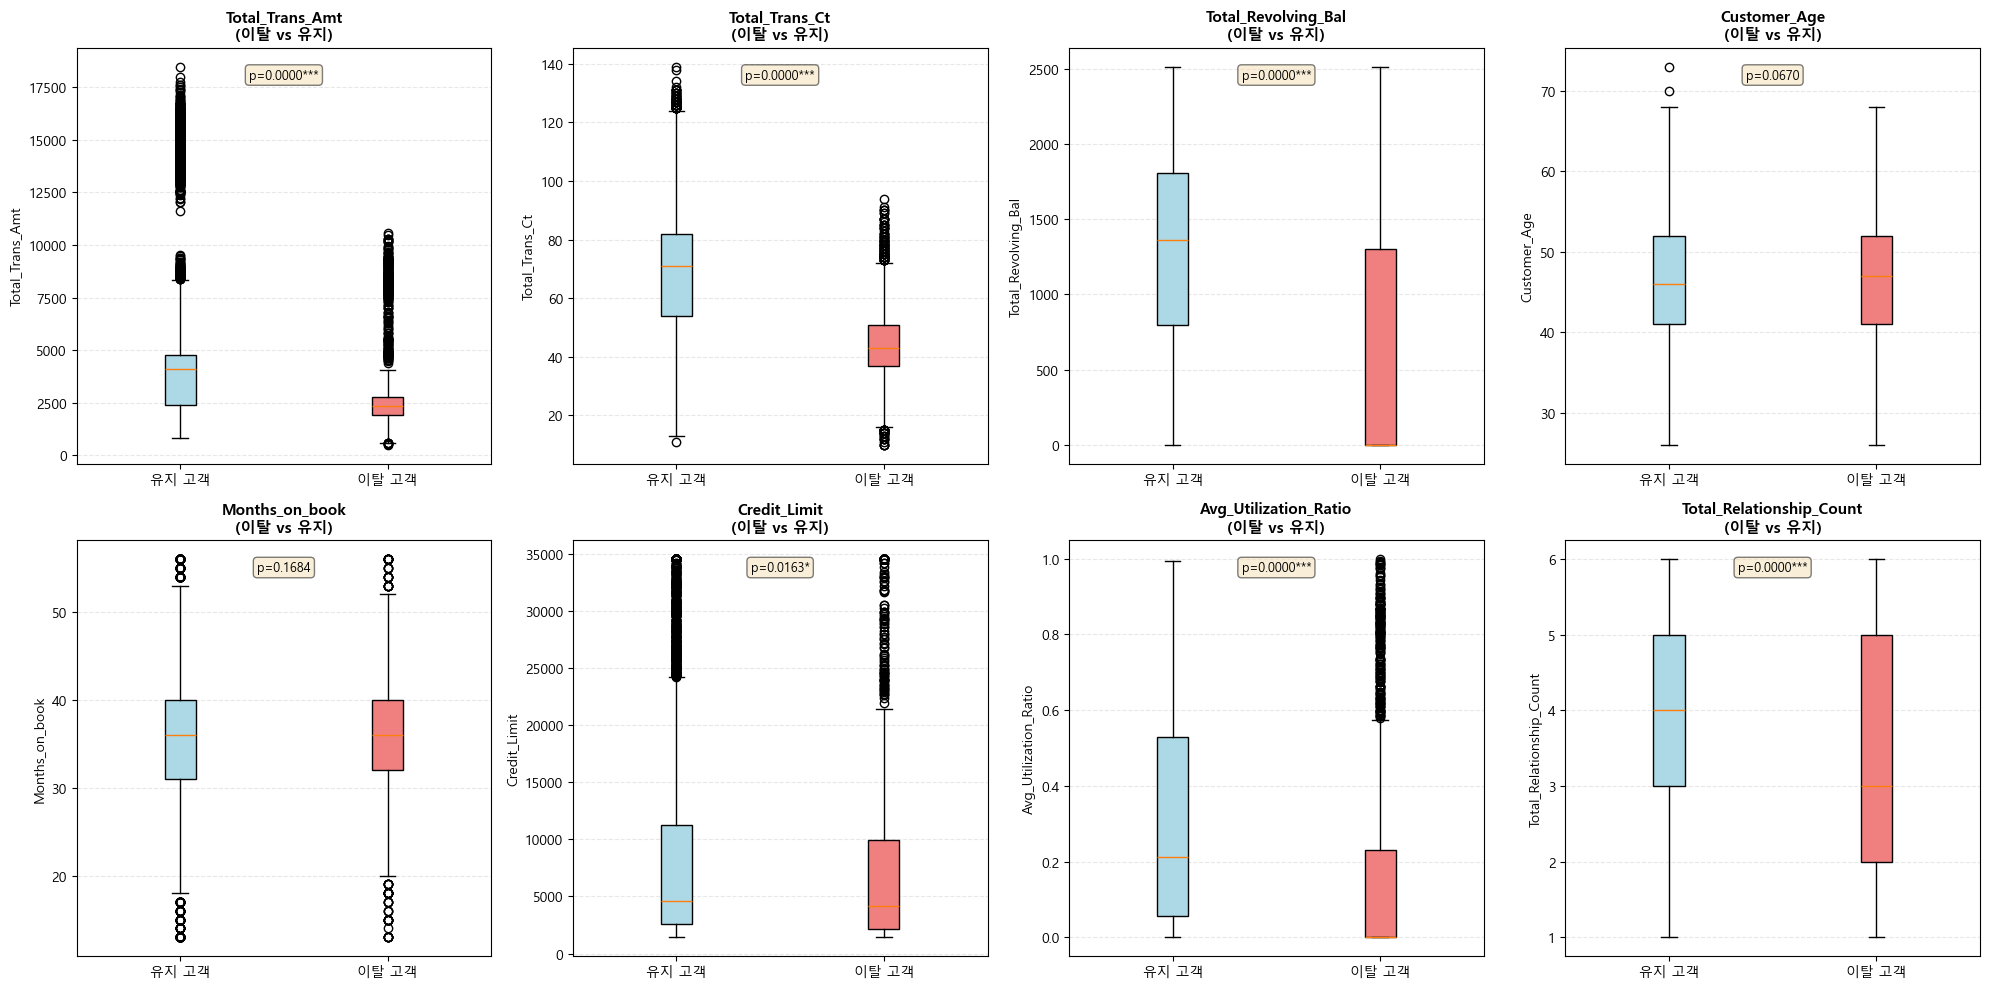


분석 완료!

주요 발견사항:
- 전체 평균 이탈률: 0.1607 (16.07%)
- 통계적으로 유의한 변수 수: 6개
- 가장 큰 차이를 보이는 변수: Total_Trans_Ct (차이: -23.74)


In [33]:
# 통계적 변수 분석: 범주형 변수별 이탈률 및 연속형 변수 통계적 비교

from scipy import stats

# 1. 범주형 변수별 이탈률 분석
print("=" * 60)
print("1. 범주형 변수별 이탈률 분석")
print("=" * 60)

# Attrition_Binary가 없으면 생성
if 'Attrition_Binary' not in df.columns:
    df['Attrition_Binary'] = df['Attrition_Flag'].map({
        "Existing Customer": 0,
        "Attrited Customer": 1
    })

# 주요 범주형 변수들
categorical_vars = ['Dependent_count', 'Gender', 'Education_Level', 
                    'Marital_Status', 'Income_Category', 'Card_Category']

# 각 범주형 변수별 이탈률 계산 및 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, var in enumerate(categorical_vars):
    if var in df.columns:
        # 이탈률 계산
        churn_by_var = df.groupby(var)['Attrition_Binary'].agg(['mean', 'count']).reset_index()
        churn_by_var.columns = [var, 'Churn_Rate', 'Count']
        churn_by_var = churn_by_var.sort_values('Churn_Rate', ascending=False)
        
        # 시각화
        ax = axes[idx]
        bars = ax.bar(range(len(churn_by_var)), churn_by_var['Churn_Rate'], 
                     color='steelblue', alpha=0.7)
        ax.set_xticks(range(len(churn_by_var)))
        ax.set_xticklabels(churn_by_var[var], rotation=45, ha='right')
        ax.set_ylabel('이탈률 (Churn Rate)', fontsize=10)
        ax.set_title(f'{var}별 이탈률', fontsize=12, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        
        # 전체 평균 이탈률 라인 추가
        overall_churn = df['Attrition_Binary'].mean()
        ax.axhline(y=overall_churn, color='red', linestyle='--', 
                  linewidth=2, label=f'전체 평균: {overall_churn:.3f}')
        ax.legend(fontsize=8)
        
        # 값 표시
        for i, (rate, count) in enumerate(zip(churn_by_var['Churn_Rate'], churn_by_var['Count'])):
            ax.text(i, rate + 0.01, f'{rate:.3f}\n(n={count})', 
                   ha='center', va='bottom', fontsize=7)
        
        print(f"\n[{var}]")
        print(churn_by_var.to_string(index=False))

plt.tight_layout()
plt.savefig('categorical_churn_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. 연속형 변수 통계적 비교 (이탈 고객 vs 유지 고객)
print("\n" + "=" * 60)
print("2. 연속형 변수 통계적 비교 (이탈 고객 vs 유지 고객)")
print("=" * 60)

# 주요 연속형 변수들
continuous_vars = ['Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Revolving_Bal',
                   'Customer_Age', 'Months_on_book', 'Credit_Limit',
                   'Avg_Utilization_Ratio', 'Total_Relationship_Count']

# 통계 비교 결과 저장
stat_results = []

for var in continuous_vars:
    if var in df.columns:
        # 그룹별 데이터
        churned = df[df['Attrition_Binary'] == 1][var].dropna()
        retained = df[df['Attrition_Binary'] == 0][var].dropna()
        
        if len(churned) > 0 and len(retained) > 0:
            # 기술 통계
            churned_mean = churned.mean()
            retained_mean = retained.mean()
            churned_std = churned.std()
            retained_std = retained.std()
            
            # t-test (정규성 가정)
            t_stat, p_value = stats.ttest_ind(churned, retained)
            
            # 효과 크기 (Cohen's d)
            pooled_std = np.sqrt(((len(churned) - 1) * churned_std**2 + 
                                  (len(retained) - 1) * retained_std**2) / 
                                 (len(churned) + len(retained) - 2))
            cohens_d = (churned_mean - retained_mean) / pooled_std if pooled_std > 0 else 0
            
            stat_results.append({
                'Variable': var,
                'Churned_Mean': churned_mean,
                'Retained_Mean': retained_mean,
                'Difference': churned_mean - retained_mean,
                'Churned_Std': churned_std,
                'Retained_Std': retained_std,
                'T_Statistic': t_stat,
                'P_Value': p_value,
                'Cohens_D': cohens_d,
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })

# 결과를 DataFrame으로 변환
stat_df = pd.DataFrame(stat_results)
stat_df = stat_df.sort_values('P_Value')

print("\n통계적 검정 결과 (t-test):")
print(stat_df.to_string(index=False))

# 시각화: 박스플롯으로 비교
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, var in enumerate(continuous_vars[:8]):
    if var in df.columns:
        ax = axes[idx]
        data_to_plot = [
            df[df['Attrition_Binary'] == 0][var].dropna(),
            df[df['Attrition_Binary'] == 1][var].dropna()
        ]
        
        bp = ax.boxplot(data_to_plot, labels=['유지 고객', '이탈 고객'], 
                       patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][1].set_facecolor('lightcoral')
        
        ax.set_ylabel(var, fontsize=10)
        ax.set_title(f'{var}\n(이탈 vs 유지)', fontsize=11, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        
        # 통계적 유의성 표시
        if var in stat_df['Variable'].values:
            p_val = stat_df[stat_df['Variable'] == var]['P_Value'].values[0]
            sig_text = f"p={p_val:.4f}" + ("***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "")
            ax.text(0.5, 0.95, sig_text, transform=ax.transAxes, 
                   ha='center', va='top', fontsize=9, 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('continuous_statistical_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("분석 완료!")
print("=" * 60)
print("\n주요 발견사항:")
print(f"- 전체 평균 이탈률: {df['Attrition_Binary'].mean():.4f} ({df['Attrition_Binary'].mean()*100:.2f}%)")
print(f"- 통계적으로 유의한 변수 수: {len(stat_df[stat_df['Significant'] == 'Yes'])}개")
print(f"- 가장 큰 차이를 보이는 변수: {stat_df.iloc[0]['Variable']} (차이: {stat_df.iloc[0]['Difference']:.2f})")

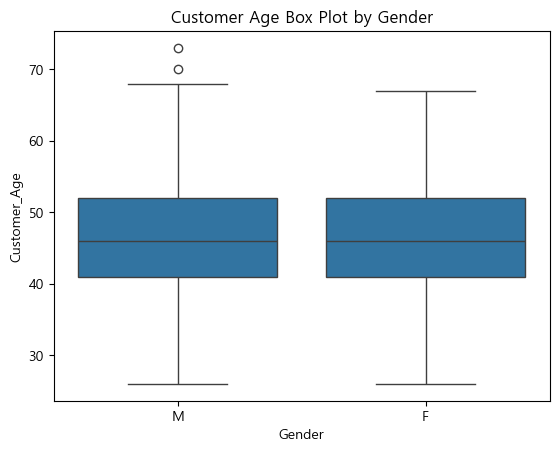

In [32]:
# 고객 연령대별 성별 분포 박스플롯 생성

sns.boxplot(x="Gender", y="Customer_Age", data=df)
plt.title("Customer Age Box Plot by Gender")
plt.show()

그래프가 저장되었습니다: boxplot_outliers_by_column.png


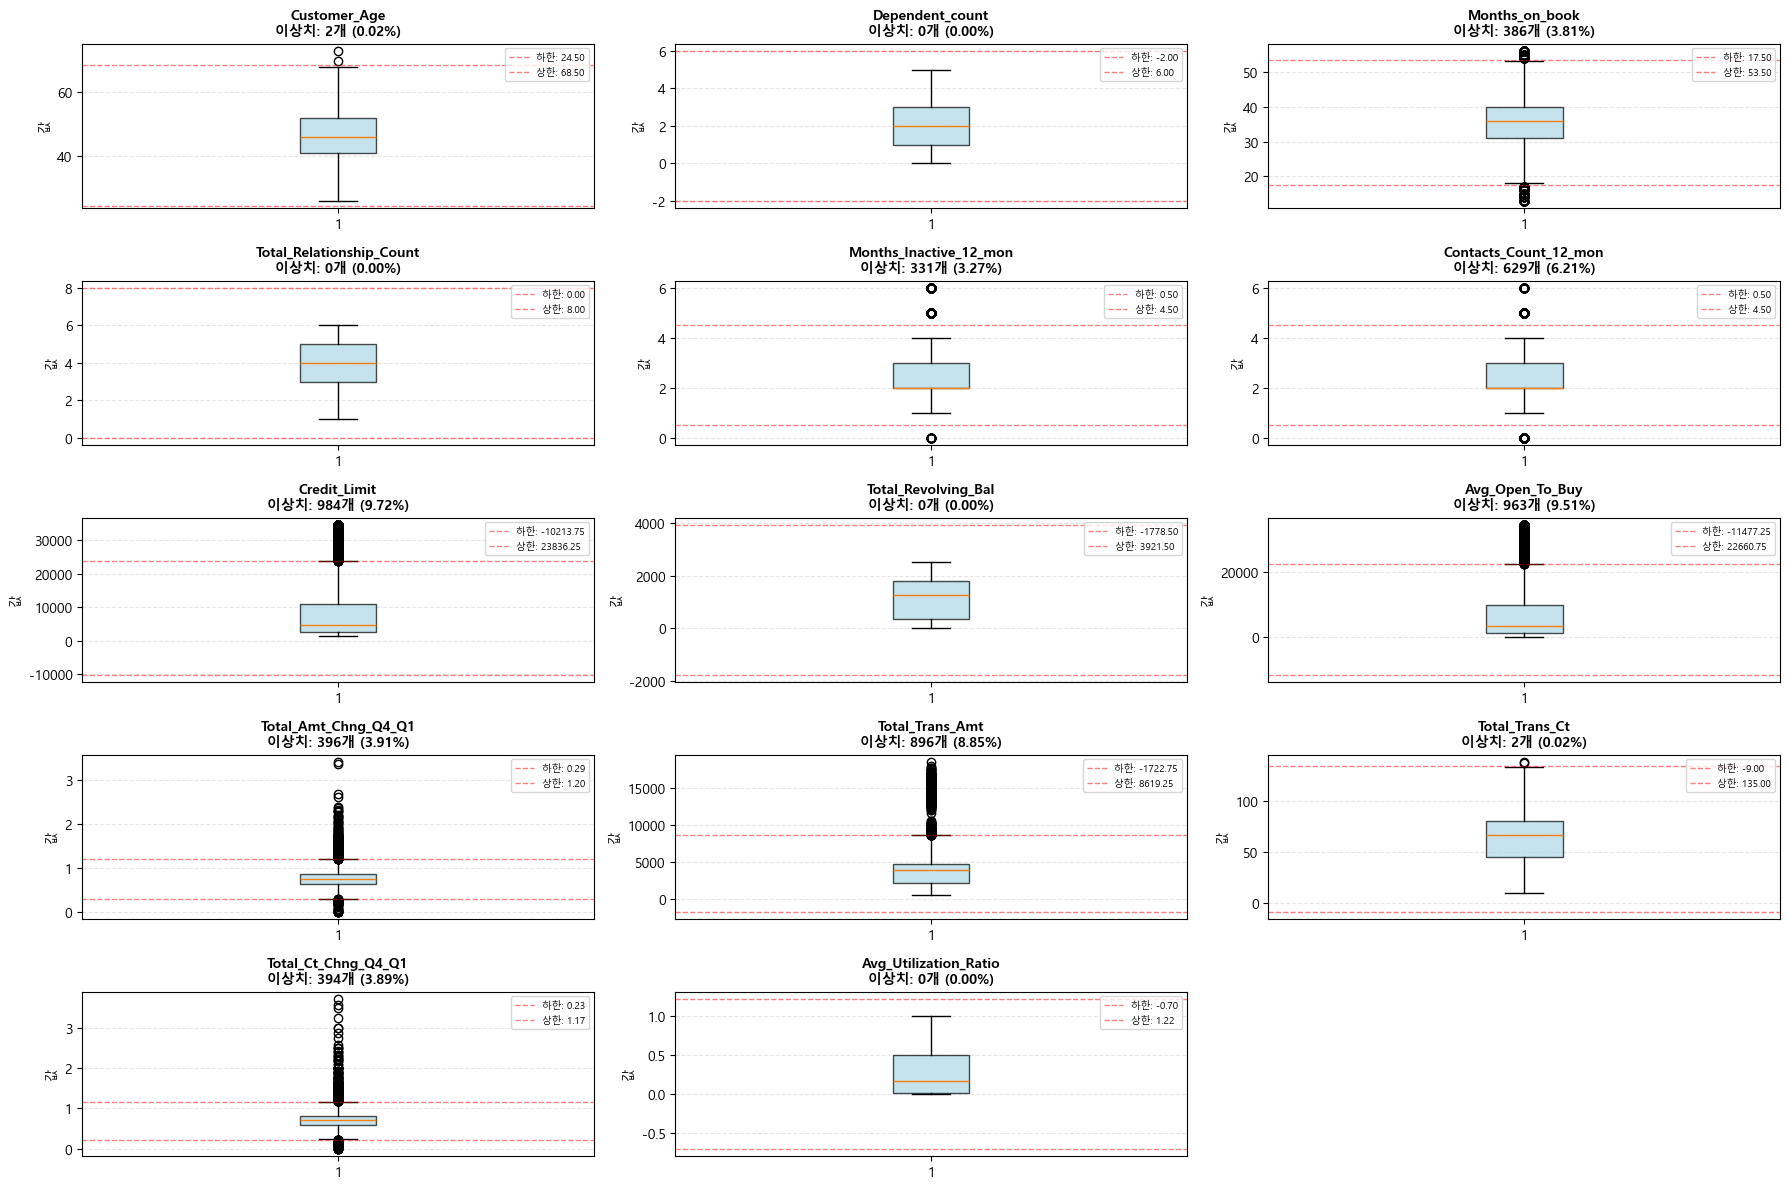


이상치 탐지 요약 정보
                          count      rate  lower_bound  upper_bound     min        max
Credit_Limit              984.0  9.716599   -10213.750    23836.250  1438.3  34516.000
Avg_Open_To_Buy           963.0  9.509233   -11477.250    22660.750     3.0  34516.000
Total_Trans_Amt           896.0  8.847635    -1722.750     8619.250   510.0  18484.000
Contacts_Count_12_mon     629.0  6.211119        0.500        4.500     0.0      6.000
Total_Amt_Chng_Q4_Q1      396.0  3.910339        0.289        1.201     0.0      3.397
Total_Ct_Chng_Q4_Q1       394.0  3.890590        0.228        1.172     0.0      3.714
Months_on_book            386.0  3.811593       17.500       53.500    13.0     56.000
Months_Inactive_12_mon    331.0  3.268490        0.500        4.500     0.0      6.000
Customer_Age                2.0  0.019749       24.500       68.500    26.0     73.000
Total_Trans_Ct              2.0  0.019749       -9.000      135.000    10.0    139.000
Total_Relationship_Count    0

In [34]:
# Outlier 탐지를 위한 칼럼별 박스플롯 함수

def plot_boxplots_by_column(df, columns=None, figsize=(15, 10), cols_per_row=3, save_path=None):
    """
    숫자형 칼럼별로 박스플롯을 그려서 이상치를 탐지하는 함수
    
    Parameters:
    -----------
    df : pandas.DataFrame
        분석할 데이터프레임
    columns : list, optional
        분석할 칼럼 리스트. None이면 모든 숫자형 칼럼을 자동으로 선택
    figsize : tuple, optional
        전체 그림 크기 (기본값: (15, 10))
    cols_per_row : int, optional
        한 행에 표시할 박스플롯 개수 (기본값: 3)
    save_path : str, optional
        그래프를 저장할 경로. None이면 저장하지 않음
    
    Returns:
    --------
    outlier_info : dict
        각 칼럼별 이상치 개수와 비율 정보
    """
    # 숫자형 칼럼 자동 선택
    if columns is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        # Attrition_Binary 같은 타겟 변수는 제외 (선택사항)
        if 'Attrition_Binary' in numeric_cols:
            numeric_cols.remove('Attrition_Binary')
        columns = numeric_cols
    
    # 칼럼이 없으면 종료
    if len(columns) == 0:
        print("분석할 숫자형 칼럼이 없습니다.")
        return {}
    
    # 행 개수 계산
    n_cols = len(columns)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row
    
    # 서브플롯 생성
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if cols_per_row == 1 else axes
    
    # 이상치 정보 저장용 딕셔너리
    outlier_info = {}
    
    # 각 칼럼별로 박스플롯 그리기
    for idx, col in enumerate(columns):
        if col not in df.columns:
            continue
            
        ax = axes[idx]
        data = df[col].dropna()
        
        if len(data) == 0:
            ax.text(0.5, 0.5, f'{col}\n(데이터 없음)', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
            continue
        
        # 박스플롯 그리기
        bp = ax.boxplot(data, vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][0].set_alpha(0.7)
        
        # 이상치 계산 (IQR 방법)
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_count = len(outliers)
        outlier_rate = (outlier_count / len(data)) * 100
        
        # 이상치 정보 저장
        outlier_info[col] = {
            'count': outlier_count,
            'rate': outlier_rate,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'min': data.min(),
            'max': data.max(),
            'mean': data.mean(),
            'median': data.median()
        }
        
        # 제목 설정
        title = f'{col}\n이상치: {outlier_count}개 ({outlier_rate:.2f}%)'
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_ylabel('값', fontsize=9)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        
        # 이상치 경계선 표시
        ax.axhline(y=lower_bound, color='red', linestyle='--', 
                  linewidth=1, alpha=0.5, label=f'하한: {lower_bound:.2f}')
        ax.axhline(y=upper_bound, color='red', linestyle='--', 
                  linewidth=1, alpha=0.5, label=f'상한: {upper_bound:.2f}')
        ax.legend(fontsize=7, loc='upper right')
    
    # 사용하지 않는 서브플롯 숨기기
    for idx in range(len(columns), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    
    # 저장
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"그래프가 저장되었습니다: {save_path}")
    
    plt.show()
    
    # 이상치 정보 요약 출력
    print("\n" + "="*80)
    print("이상치 탐지 요약 정보")
    print("="*80)
    outlier_summary = pd.DataFrame(outlier_info).T
    outlier_summary = outlier_summary.sort_values('rate', ascending=False)
    print(outlier_summary[['count', 'rate', 'lower_bound', 'upper_bound', 'min', 'max']].to_string())
    print("="*80)
    
    return outlier_info

# 함수 사용 예시
outlier_info = plot_boxplots_by_column(
    df, 
    columns=None,  # None이면 모든 숫자형 칼럼 자동 선택
    figsize=(18, 12), 
    cols_per_row=3,
    save_path='boxplot_outliers_by_column.png'
)


C:\Users\dlaud\AppData\Local\Temp\ipykernel_28156\1336083816.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Income_Category', y='Churn', data=grouped_churn, palette='viridis')


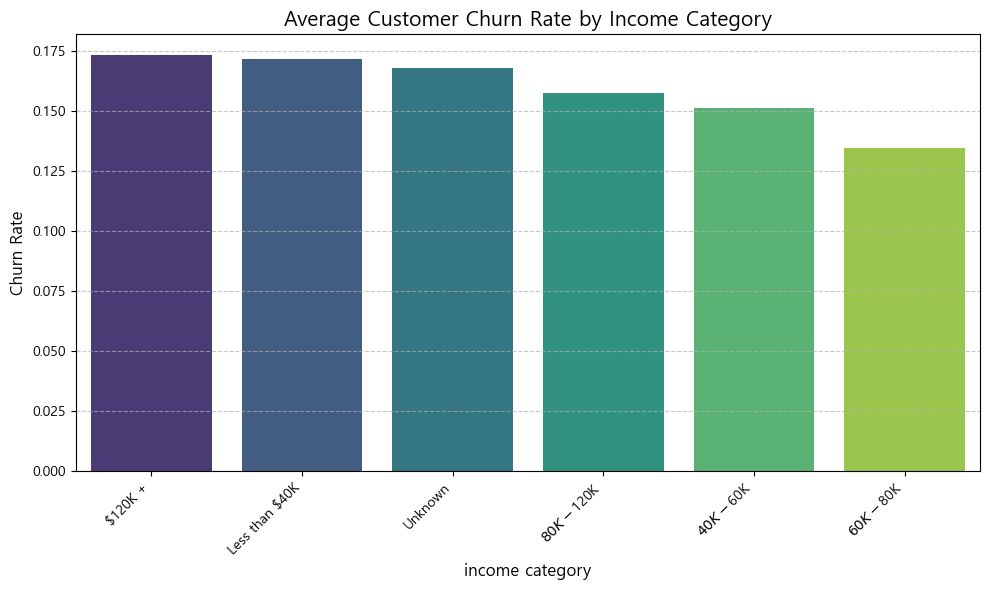

In [35]:
# Attrition_Flag를 이진 변수(1: 이탈, 0: 유지)로 변환
df['Churn'] = df['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)


# 타깃(Attrition_Binary)과 동일하거나 중복 의미인 칼럼은 제외한 뒤 상위 5개 특성을 탐색

# 이탈률 분석을 위한 그룹화: 'Income_Category' (소득 범주) 및 'Churn'
grouped_churn = df.groupby('Income_Category')['Churn'].mean().reset_index()
grouped_churn = grouped_churn.sort_values(by='Churn', ascending=False)

# --- 소득 범주별 평균 이탈률 막대 그래프 (Bar Chart) 출력 코드 ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Income_Category', y='Churn', data=grouped_churn, palette='viridis')
plt.title('Average Customer Churn Rate by Income Category', fontsize=15)
plt.xlabel('income category', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 그래프를 화면에 출력합니다. (plt.savefig() 대신 plt.show() 사용)
plt.show()

if 'Churn' in df.columns:
    df = df.drop(columns=['Churn'])


--- [1. 전체 평균 이탈률] ---
전체 평균 이탈률: 0.1607 (16.07%)

--- [1. 다양한 이탈률 평균 그래프 코드 생성] ---
-> 소득 범주별 이탈률 막대 그래프: 'churn_rate_by_income.png' 저장


C:\Users\dlaud\AppData\Local\Temp\ipykernel_28156\3872792532.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Income_Category', y='Churn', data=grouped_churn, palette='viridis')


-> 고객 연령별 이탈 여부 밀도 그래프: 'churn_distribution_by_age.png' 저장


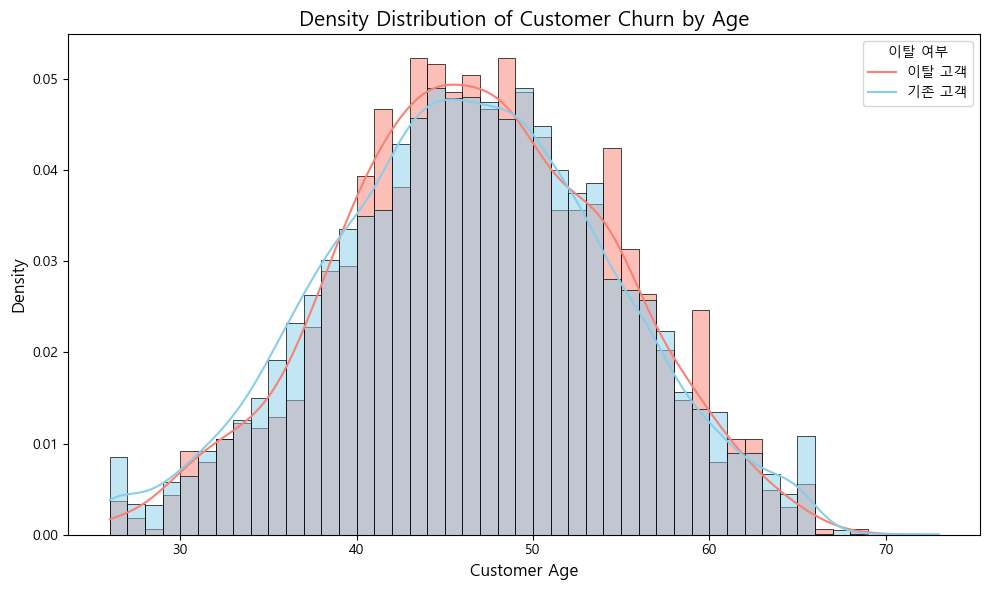

In [ ]:
# --- 이탈률 분석 및 그래프 생성 준비 (Churn Analysis & Prep) ---

# Attrition_Flag를 이진 변수(1: 이탈, 0: 유지)로 변환
df['Churn'] = df['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

# 전체 평균 이탈률 계산
overall_churn_rate = df['Churn'].mean()
print(f"\n--- [1. 전체 평균 이탈률] ---")
print(f"전체 평균 이탈률: {overall_churn_rate:.4f} ({overall_churn_rate * 100:.2f}%)")

# 이탈률 분석을 위한 2개 열 선택: 'Income_Category' (소득 범주) 및 'Churn'
grouped_churn = df.groupby('Income_Category')['Churn'].mean().reset_index()
grouped_churn = grouped_churn.sort_values(by='Churn', ascending=False)

# --- 1. 다양한 그래프 코드 생성 (Visualization Code Generation) ---
print("\n--- [1. 다양한 이탈률 평균 그래프 코드 생성] ---")

# 1-A. 소득 범주별 평균 이탈률 (막대 그래프: Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x='Income_Category', y='Churn', data=grouped_churn, palette='viridis')
plt.title('소득 범주별 고객 평균 이탈률', fontsize=15)
plt.xlabel('소득 범주', fontsize=12)
plt.ylabel('평균 이탈률 (Churn Rate)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('churn_rate_by_income.png')
print("-> 소득 범주별 이탈률 막대 그래프: 'churn_rate_by_income.png' 저장")
plt.close()

# 1-B. 고객 연령별 이탈 여부 분포 (밀도 그래프: Distribution Plot)
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df, 
    x='Customer_Age', 
    hue='Attrition_Flag', 
    kde=True, 
    palette={'Existing Customer': 'skyblue', 'Attrited Customer': 'salmon'},
    stat="density", 
    common_norm=False,
    linewidth=0.5
)
plt.title('Density Distribution of Customer Churn by Age', fontsize=15)
plt.xlabel('Customer Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='이탈 여부', labels=['이탈 고객', '기존 고객'])
plt.tight_layout()
plt.savefig('churn_distribution_by_age.png')
print("-> 고객 연령별 이탈 여부 밀도 그래프: 'churn_distribution_by_age.png' 저장")
plt.show()

if 'Churn' in df.columns:
    df = df.drop(columns=['Churn'])

## 4. 상관관계 분석

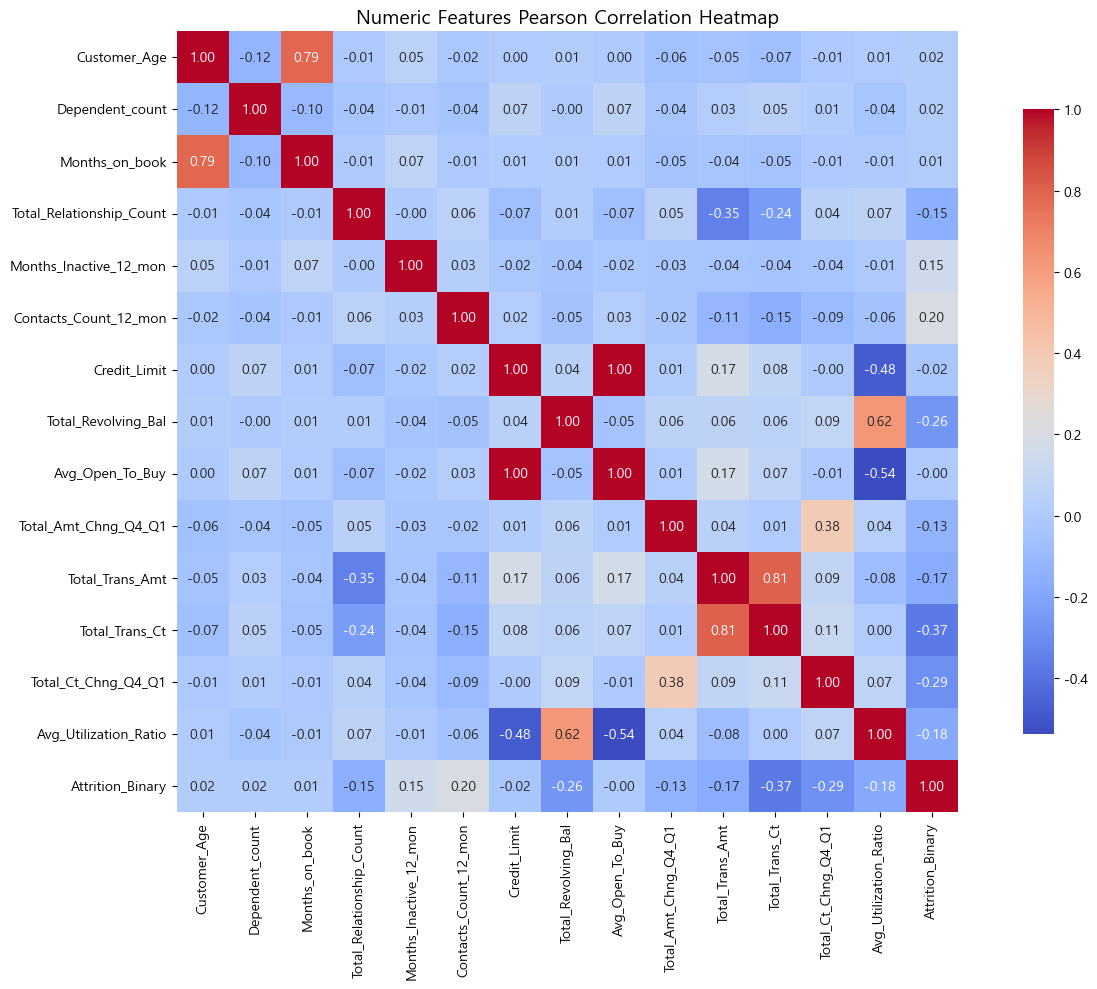

In [42]:
# Seaborn 기반 상관계수 히트맵 (Pearson)
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr(method="pearson")

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Numeric Features Pearson Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.savefig("Heatmap", dpi=1000, bbox_inches='tight')
plt.show()

Attrition_Binary와의 Pearson 상관계수 Top 5
Total_Trans_Ct          -0.371403
Total_Ct_Chng_Q4_Q1     -0.290054
Total_Revolving_Bal     -0.263053
Contacts_Count_12_mon    0.204491
Avg_Utilization_Ratio   -0.178410
Name: Attrition_Binary, dtype: float64
-> 그래프 저장 완료: 'top5_pearson_correlations_attrition.png'


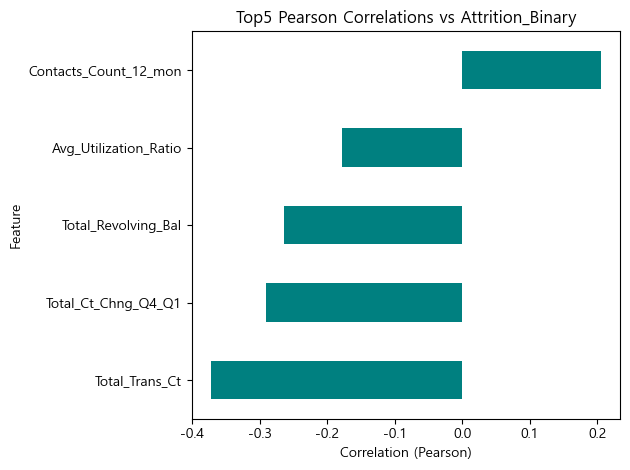

In [44]:
# Attrition_Binary 기준 Pearson 상관계수 Top 5
numeric_df = df.select_dtypes(include=[np.number])

# Attrition_Binary와 다른 변수들 간의 상관계수 계산
corr_matrix = numeric_df.corr(method="pearson")
attrition_corr = corr_matrix["Attrition_Binary"].drop("Attrition_Binary")

# 절대값 기준으로 정렬하여 Top 5 추출
top5_corr = attrition_corr.reindex(attrition_corr.abs().sort_values(ascending=False).index).head(5)

print("Attrition_Binary와의 Pearson 상관계수 Top 5")
print(top5_corr)

top5_corr.sort_values().plot(kind="barh", color="teal")
plt.title("Top5 Pearson Correlations vs Attrition_Binary")
plt.xlabel("Correlation (Pearson)")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("top5_pearson_correlations_attrition.png", dpi=300, bbox_inches='tight')
print("-> 그래프 저장 완료: 'top5_pearson_correlations_attrition.png'")
plt.show()


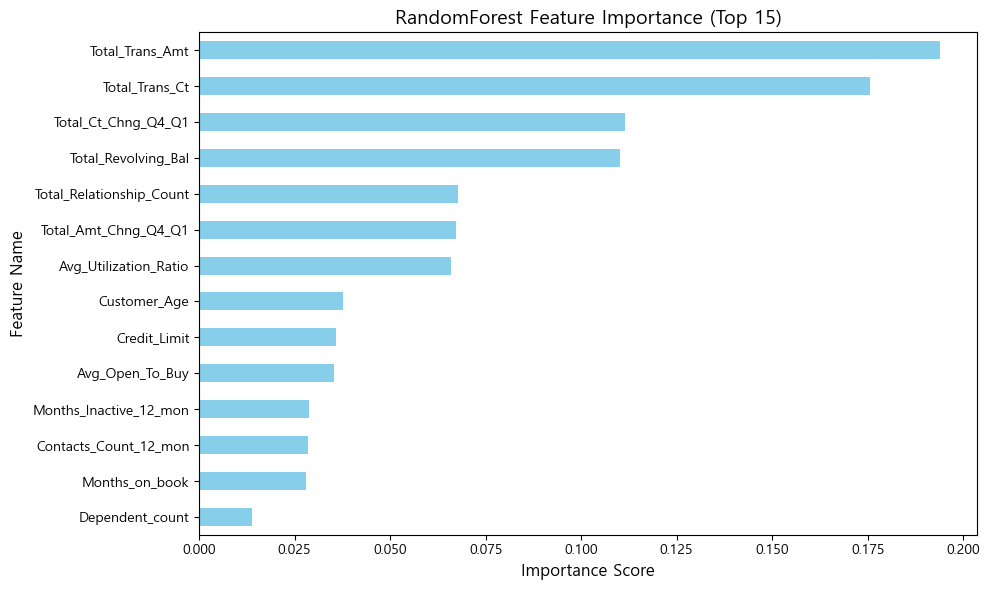

In [45]:
# 숫자형 데이터 선택
numeric_df = df.select_dtypes(include=[np.number])

X = numeric_df.drop(columns=["Attrition_Binary"], errors="ignore")
y = numeric_df["Attrition_Binary"]

# 결측치 처리
X = X.fillna(0)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# RandomForest 모델 학습
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# Feature Importance 계산
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

# 그래프 생성
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.title("RandomForest Feature Importance (Top 15)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.tight_layout()
plt.show()

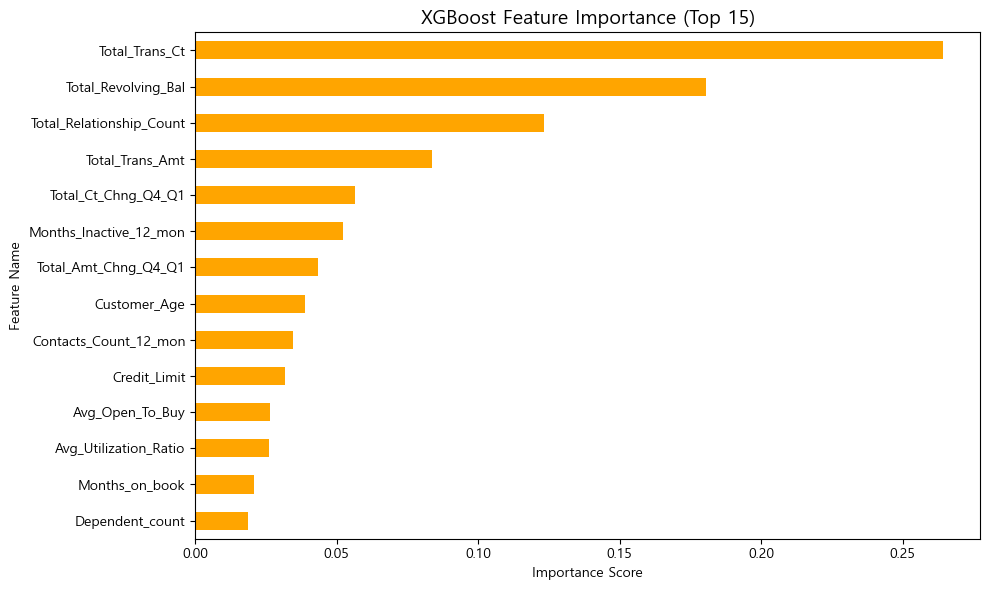


=== XGBoost 상위 Feature 15개 ===
Total_Trans_Ct              0.264094
Total_Revolving_Bal         0.180611
Total_Relationship_Count    0.123225
Total_Trans_Amt             0.083670
Total_Ct_Chng_Q4_Q1         0.056375
Months_Inactive_12_mon      0.052135
Total_Amt_Chng_Q4_Q1        0.043367
Customer_Age                0.038733
Contacts_Count_12_mon       0.034421
Credit_Limit                0.031807
Avg_Open_To_Buy             0.026296
Avg_Utilization_Ratio       0.025930
Months_on_book              0.020737
Dependent_count             0.018598
dtype: float32

XGBoost 모델 정확도 테스트용:
Train Score: 0.9981
Test Score:  0.9654


In [46]:
# XGBoost 상관관계 분석

numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=["Attrition_Binary"], errors="ignore")
y = numeric_df["Attrition_Binary"]


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6) XGBoost 모델 학습
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

# 7) Feature Importance 계산
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_xgb = xgb_importance.sort_values(ascending=False).head(15)

# 8) 그래프 출력
plt.figure(figsize=(10, 6))
top_xgb.sort_values().plot(kind='barh', color='orange')
plt.title("XGBoost Feature Importance (Top 15)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# 9) 추가 분석 결과 출력
print("\n=== XGBoost 상위 Feature 15개 ===")
print(top_xgb)

print("\nXGBoost 모델 정확도 테스트용:")
print(f"Train Score: {xgb_model.score(X_train, y_train):.4f}")
print(f"Test Score:  {xgb_model.score(X_test, y_test):.4f}")

## 5. 최종 Feature Engineering 아이디어

In [47]:
# 파생 변수 생성 예시
print("파생 변수 생성 중...\n")

# NaN 값 처리 후 Feature Engineering

# 1) 거래 변화율 (거래 횟수 대비 분기 변화 비율)
df["Trans_Change_Ratio"] = (
    df["Total_Trans_Ct"] / (df["Total_Ct_Chng_Q4_Q1"] + 1)
)
print("✓ 거래 변화율 생성")

# 2) 비활동 기반 리스크 스코어
df["Inactivity_Score"] = (
    df["Months_Inactive_12_mon"] * df["Avg_Utilization_Ratio"]
)
print("✓ 비활동 기반 리스크 스코어 생성")

# 3) 고객 참여도 스코어 (Engagement Score)
df["Engagement_Score"] = (
    df["Total_Trans_Amt"] * 0.4 +
    df["Total_Trans_Ct"] * 0.4 -
    df["Months_Inactive_12_mon"] * 0.2
)
print("✓ 고객 참여도 스코어 생성")

# 4) Utilization 기반 위험 구간화
# Avg_Utilization_Ratio의 NaN 값을 먼저 0으로 채우기

df["Utilization_Risk_Level"] = pd.cut(
    df["Avg_Utilization_Ratio"].fillna(0),
    bins=[0, 0.3, 0.6, 1.0],
    labels=[0, 1, 2],
    include_lowest=True
).astype(int)
print("✓ Utilization 기반 위험 구간화 생성")

print("✓ Feature Engineering 완료!")
print(f"생성된 파생 변수: Trans_Change_Ratio, Inactivity_Score, Engagement_Score, Utilization_Risk_Level")
print(f"최종 데이터 shape: {df.shape}")
print("\n파생 변수 생성 완료!")

파생 변수 생성 중...

✓ 거래 변화율 생성
✓ 비활동 기반 리스크 스코어 생성
✓ 고객 참여도 스코어 생성
✓ Utilization 기반 위험 구간화 생성
✓ Feature Engineering 완료!
생성된 파생 변수: Trans_Change_Ratio, Inactivity_Score, Engagement_Score, Utilization_Risk_Level
최종 데이터 shape: (10127, 25)

파생 변수 생성 완료!
